###Playing Blackjack with Monte Carlo Methods

#####Introduction

In part 1, we considered a very simple problem, the n-armed bandit problem, and devised an appropriately very simple algorithm to solve it ($\epsilon$-greedy evaluation). In that case, the problem only has a single state: a choice among 10 actions with stationary probability distributions of rewards. Let's up the ante a bit and consider a more interesting problem with multiple (yet finite) states: the card game black jack (aka 21). Hunker down, this is a long one.

Rules and game-play of blackjack (check out https://www.youtube.com/watch?v=qd5oc9hLrXg if necessary):
1. There is a dealer and 1 or more players that independently play against the dealer.
2. Each player is delt 2 cards face-up. The dealer is delt two cards, one face-up, one face-down.
3. The goal is to get the sum of your cards value to be as close to 21 as possible without going over.
4. After the initial cards are dealt, each player can choose to 'stay' or 'hit' (ask for another card).
5. The dealer always follows this policy: hit until cards sum to 17 or more, then stay.
6. If the dealer is closer to 21, the dealer wins and the player loses, and vice versa.

So what's the state space for this problem? It's relatively large, much much larger than the single state in n-armed bandit. In reinforcement learning, a state is all information available to the agent (the decision maker) at a particular time $t$. The reason why the n-armed bandit state space includes just 1 state is because the agent is only aware of the same 10 actions at any time, no new information is available nor do the actions change.

So what are all the possible combinations of information available to the agent (the player) in blackjack? Well, the player starts with two cards, so there is the combination of all 2 playing cards. Additionally, the player knows one of the two cards that the dealer has. Thus, there are a lot of possible states (around 200). As with any RL problem, our ultimate goal is to find the best _policy_ to maximize our rewards. 

A policy is roughly equivalent to a strategy. There are reinforcement learning methods that essentially rely on brute force to compute every possible action-state pair (every possible action in a given state) and the rewards received to find an optimal policy, but for most of the problems we care about, the state-action space is much too large for brute force methods to be computationally feasible. Thus we must rely on experience, i.e. playing the game, trying out various actions and learning what seems to result in the greatest reward returns; and we need to devise an algorithm that captures this experiential learning process.


The most important take-aways from part 1 and 2 are the concepts of state values, state-action values, and policies. Reinforcement learning is in the business of determining the value of states or of actions taken in a state. In our case, we will primarily concern ourselves with action values (value of an action taken in a given state) because it is more intuitive in how we can make an optimal action. I find the value of being in a given state less intuitive because the value of a state depends on your policy. For example, what is the value of being in a state of a blackjack game where your cards total to 20? Most people would say that's a pretty good position to be in, but it's only a good state if your policy is to stay and not hit. If your policy is to hit when you have 20 (of course it's a bad policy), then that state isn't very good. On the other hand, we can ask the question of, what's the value of hitting when I have 20 versus the value of staying when I have 20, and then just choose whichever action has the highest value. Of course staying would produce the highest value in this state (on average).

Our main computational effort, therefore, is in iteratively improving our estimates for the values of states or state-action pairs. In parts 1 and 2, we keep track of every single state-action pair we encounter, and record the rewards we receive for each and average them over time. Thus, over many iterations, we go from knowing nothing about the value of state-actions to knowing enough to be able to choose the highest value actions. Problems like the n-armed bandit problem and blackjack have a small enough state or state-action space that we can record and average rewards in a lookup table, giving us the exact average rewards for each state-action pair. Most interesting problems, however, have a state space that is continuous or otherwise too large to use a lookup table. That's when we must use function approximation (e.g. neural networks) methods to serve as our $Q$ function in determining the value of states or state-actions.  We will have to wait for part 3 for neural networks.

####Learning with Markov Decision Processes

A Markov decision process (MDP) is a decision that can be made knowing only the current state, without knowledge of or reference to previous states or the path taken to the current state. That is, the current state contains enough information to choose optimal actions to maximize future rewards. Most RL algorithms assume that the problems to be learned are (at least approximately) Markov decision processes. Blackjack is clearly an MDP because we can play the game successfully by just knowing our current state (i.e. what cards we have + the dealer's one face-up card). Google DeepMind's deep Q-learning algorithm learned to play Atari games from just raw pixel data and the current score. Does raw pixel data and the score satisfy the Markov property? Not exactly. Say the game is Pacman, if our state is the raw pixel data from our current frame, we have no idea if that enemy a few tiles away is approaching us or moving away from us, and that would strongly influence our choice of actions to take. This is why DeepMind's implementation actually feeds in the last 4 frames of gameplay, effectively changing a non-Markov decision process into an MDP. With the last 4 frames, the agent has access to the direction and speed of each enemy (and itself).

####Terminology & Notation Review
1. $Q_k(s, a)$ is the function that accepts an action and state and returns the value of taking that action in that state at time step $k$. This is fundamental to RL. We need to know the relative values of every state or state-action pair.
2. $\pi$ is a policy, a stochastic strategy or rule to choose action $a$ given a state $s$. Think of it as a function, $\pi(s)$, that accepts state, $s$ and returns the action to be taken. There is a distinction between the $\pi(s)$ _function_ and a specific policy $\pi$. Our implementation of $\pi(s)$ as a function is often to just choose the action $a$ in state $s$ that has the highest average return based on historical results, $argmaxQ(s,a)$. As we gather more data and these average returns become more accurate, the actual policy $\pi$ may change. We may start out with a policy of "hit until total is 16 or more then stay" but this policy may change as we gather more data. Our implemented $\pi(s)$ function, however, is programmed by us and does not change.
3. $G_t$, return. The expected cumulative reward from starting in a given state until the end of an episode (i.e. game play), for example. In our case we only give a reward at the end of the game, there are no rewards at each time step or move.
4. Episode: The full sequence of steps leading to a terminal state and receiving a return. E.g. from the beginning of a blackjack game until the terminal state (someone winning) constitutes an episode of play.
5. $v_\pi$, a function that determines the value of a state given a policy $\pi$. We do not really concern our selves with state values here, we focus on action values.

###Monte Carlo & Tabular Methods

Monte Carlo is going to feel very familiar to how we solved the n-armed bandit problem from part 1. We will store the history of our state-action pairs associated with their values in a table, and then refer to this table during learning to calculate our expected rewards, $Q_k$.

From Wikipedia, Monte Carlo methods "rely on repeated random sampling to obtain numerical results." We'll use random sampling of states and state-action pairs and observe rewards and then iteratively revise our policy, which will hopefully converge on the optimal policy as we explore every possible state-action couple.

Here are some important points:

1. We will asign a reward of +1 to winning a round of blackjack, -1 for losing, and 0 for a draw.
2. We will establish a table (python dictionary) where each key corresponds to a particular state-action pair and each value is the value of that pair. i.e. the average reward received for that action in that state.
3. The state consists of the player's card total, whether or not the player has a useable ace, and the dealer's one face-up card

###Blackjack Game Implementation
Below I've implemented a blackjack game. I think I've commented it well enough to be understood but it's not critical that you understand the game implementation since we're just concerned with how to learn to play the game with machine learning.

This implementation is completely functional and stateless. I mean that this implementation is just a group of functions that accept data, transform that data and return new data. I intentionally avoided using OOP classes because I think it complicates things and I think functional-style programming is useful in machine learning (see my post about computational graphs to learn more). It is particularly useful in our case because it demonstrates how blackjack is an MDP. The game does not store any information, it is stateless. It merely accepts states and returns new states. The player is responsible for saving states if they want.

The state is just a Python tuple where the first element is the player's card total, the 2nd element is a boolean of whether or not the player has a useable ace. The 3rd element is the card total for the dealer and then another boolean of whether or not its a useable ace. The last element is a single integer that represents the status of the state (whether the game is in progress, the player has won, the dealer has won, or it was a draw).

We actually could implement this in a more intuitive way where we just store each player's cards and not whether or not they have a useable ace (useable means, can the ace be an 11 without losing the game by going over 21, because aces in blackjack can either be a 1 or an 11). However, as you'll see, storing the player card total and an useable ace boolean is equivalent and yet compresses our state space (without losing any information) so we can have a smaller lookup table.

In [259]:
import math
import random
#each value card has a 1:13 chance of being selected (we don't care about suits for blackjack)
#cards (value): Ace (1), 2, 3, 4, 5, 6, 7, 8, 9, 10, Jack (10), Queen (10), King (10)

def randomCard():
    card = random.randint(1,13)
    if card > 10:
        card = 10
    return card

#A hand is just a tuple e.g. (14, False), a total card value of 14 without a useable ace
#accepts a hand, if the Ace can be an 11 without busting the hand, it's useable
def useable_ace(hand):
    val, ace = hand
    return ((ace) and ((val + 10) <= 21))

def totalValue(hand):
    val, ace = hand
    if (useable_ace(hand)):
        return (val + 10)
    else:
        return val
    
def add_card(hand, card):
    val, ace = hand
    if (card == 1):
        ace = True
    return (val + card, ace)
#The first is first dealt a single card, this method finishes off his hand
def eval_dealer(dealer_hand):
    while (totalValue(dealer_hand) < 17):
        dealer_hand = add_card(dealer_hand, randomCard())
    return dealer_hand

#state: (player total, useable_ace), (dealer total, useable ace), game status; e.g. ((15, True), (9, False), 1)
#stay or hit => dec == 0 or 1
def play(state, dec):
    #evaluate
    player_hand = state[0] #val, useable ace
    dealer_hand = state[1]
    if dec == 0: #action = stay
        #evaluate game; dealer plays
        dealer_hand = eval_dealer(dealer_hand)
        
        player_tot = totalValue(player_hand)
        dealer_tot = totalValue(dealer_hand)
        status = 1
        if (dealer_tot > 21):
            status = 2 #player wins
        elif (dealer_tot == player_tot):
            status = 3 #draw
        elif (dealer_tot < player_tot):
            status = 2 #player wins
        elif (dealer_tot > player_tot):
            status = 4 #player loses
            
    elif dec == 1: #action = hit
        #if hit, add new card to player's hand
        player_hand = add_card(player_hand, randomCard())
        d_hand = eval_dealer(dealer_hand)
        player_tot = totalValue(player_hand)
        status = 1
        if (player_tot == 21): 
            if (totalValue(d_hand) == 21):
                status = 3 #draw
            else:
                status = 2 #player wins!
        elif (player_tot > 21):
            status = 4 #player loses
        elif (player_tot < 21):
            #game still in progress
            status = 1
    state = (player_hand, dealer_hand, status)

    return state

#start a game of blackjack, returns a random initial state
def initGame():
    status = 1 #1=in progress; 2=player won; 3=draw; 4 = dealer won/player loses
    player_hand = add_card((0, False), randomCard())
    player_hand = add_card(player_hand, randomCard())
    dealer_hand = add_card((0, False), randomCard())
    #evaluate if player wins from first hand
    if totalValue(player_hand) == 21:
        if totalValue(dealer_hand) != 21:
            status = 2 #player wins after first deal!
        else:
            status = 3 #draw
        
    state = (player_hand, dealer_hand, status)
    return state

There you have it. We've implemented a simplified blackjack game (no double downs or splitting) with just a few functions that basically just consist of some if-else conditions. Here's some sample game-play so you know how to use it.

In [250]:
state = initGame()
print(state)

((7, False), (5, False), 1)


In [251]:
state = play(state, 1) #Player has total of 7, let's hit
print(state)

((9, False), (5, False), 1)


In [252]:
state = play(state, 1) #player has a total of 9, let's hit
print(state)

((15, False), (5, False), 1)


In [253]:
state = play(state, 0) #player has a total of 15, let's stay
print(state)

((15, False), (20, False), 4)


Damn, I lost. Oh well, that should demonstrate how to use the blackjack game. As a user, we only have to concern ourselves with the `initGame()` and `play()` functions. `initGame()` just creates a random state by dealing the player 2 random cards and the dealer one random card and setting the game status to 1 ('in progress'). `play()` accepts a state and an action (either 0 or 1, for 'stay' and 'hit', respectively). Please keep in mind the distinction between a blackjack game state and the state with respect to our Reinforcement Learning (RL) algorithm. We will compress the states a bit by ignoring the useable ace boolean for the dealer's hand because the dealer only shows a single card and if it's an ace the player has no idea if it's useable or not, so it offers no additional information to us.

###Time for Reinforcement Learning
Let's start the real fun: building our Monte Carlo-based reinforcement learning algorithm. Here's the algorithm words/math (adapted from the Sutton & Barto text):

1. Choose a random state $S_0 \in \mathcal{S}$ (some state in the set of all possible states); this is what `initGame()` does
2. Take action $A_0 \in \mathcal{A(S_0)}$ (take some action in set of all possible actions given we're in state $S_0$)
3. Generate a complete episode starting from $S_0\,\ A_0$ following policy $\pi$
4. For each pair $s, a$ occuring in the episode:
    1. $G = \text{returns/rewards following the first occurence of s,a}$
    2. If this is the first experience of $s, a$ in any episode, simply store $G$ in our $Q(s, a)$ table. If it's not the first time, then recalculate the average returns and store in $Q(s, a)$.
5. For each state $s$ in the episode: We use an $\epsilon$-greedy action select process such that $\pi(s) = argmax_a{Q(s, a)}$ most of the time but with probability $\epsilon$, $\pi(s) = random(A_0 \in \mathcal{A(S_0)})$ (basically the same as our n-armed bandit policy function). Recall that we use an epsilon-greedy policy function to ensure we have a good balance of exploration versus exploitation.

In essence, with Monte Carlo we are playing randomly initialized games, sampling the state-action pair space and recording returns. In doing so, we can iteratively update our policy $\pi$.

Let's get to coding.

In [256]:
import numpy as np

#Create a list of all the possible states
def initStateSpace():
    states = []
    for card in range(1,11):
        for val in range(11,22):
            states.append((val, False, card))
            states.append((val, True, card))
    return states

#Create a dictionary (key-value pairs) of all possible state-actions and their values
#This creates our Q-value look up table
def initStateActions(states):
    av = {}
    for state in states:
        av[(state, 0)] = 0.0
        av[(state, 1)] = 0.0
    return av
#Setup a dictionary of state-actions to record how many times we've experienced
#a given state-action pair. We need this to re-calculate reward averages
def initSAcount(stateActions):
    counts = {}
    for sa in stateActions:
        counts[sa] = 0
    return counts

#This calculates the reward of the game, either +1 for winning, 0 for draw, or -1 for losing
#We can determine this by simply substracting the game status value from 3
def calcReward(outcome):
    return 3-outcome

#This recalculates the average rewards for our Q-value look-up table
def updateQtable(av_table, av_count, returns):
    for key in returns:
        av_table[key] = av_table[key] + (1.0 / av_count[key]) * (returns[key]- av_table[key])
    return av_table
        
#returns Q-value/avg rewards for each action given a state
def qsv(state, av_table):
    stay = av_table[(state,0)]
    hit = av_table[(state,1)]
    return np.array([stay, hit])

#converts a game state of the form ((player total, ace), (dealer total, ace), status) 
#to a condensed state we'll use for our RL algorithm (player total, usable ace, dealer card)
def getRLstate(state):
    player_hand, dealer_hand, status = state
    player_val, player_ace = player_hand
    return (player_val, player_ace, dealer_hand[0])

Above we've defined basically all the functions we need to run our Monte Carlo algorithm. We initialize our state and state-action space, define methods to calculate rewards and update our state-action table (Q-value table). Below is where we'll actually run 5,000,000 Monte Carlo simulations of blackjack and fill out our Q-value table.

In [257]:
epochs = 5000000 #takes just a minute or two on my Macbook Air
epsilon = 0.1

state_space = initStateSpace()
av_table = initStateActions(state_space)
av_count = initSAcount(av_table)

for i in range(epochs):
    #initialize new game; observe current state
    state = initGame()
    player_hand, dealer_hand, status = state
    #if player's total is less than 11, increase total by adding another card
    #we do this because whenever the player's total is less than 11, you always hit no matter what
    #so we don't want to waste compute cycles on that subset of the state space
    while player_hand[0] < 11:
        player_hand = add_card(player_hand, randomCard())
        state = (player_hand, dealer_hand, status)
    rl_state = getRLstate(state) #convert to compressed version of state
    
    #setup dictionary to temporarily hold the current episode's state-actions
    returns = {} #state, action, return
    while(state[2] == 1): #while in current episode
        #epsilon greedy action selection
        act_probs = qsv(rl_state, av_table)
        if (random.random() < epsilon):
            action = random.randint(0,1)
        else:
            action = np.argmax(act_probs)#select an action
        sa = ((rl_state, action))
        returns[sa] = 0 #add a-v pair to returns list, default value to 0
        av_count[sa] += 1 #increment counter for avg calc
        state = play(state, action) #make a play, observe new state
        rl_state = getRLstate(state)
    #after an episode is complete, assign rewards to all the state-actions that took place in the episode
    for key in returns: 
        returns[key] = calcReward(state[2])
    av_table = updateQtable(av_table, av_count, returns)
print("Done")

Done


Okay, so we just ran a Monte Carlo simulation of blackjack 5,000,000 times and built up an action-value (Q-value) table that we can use to determine what the optimal action is when we're in a particular state.

How do we know if it worked? Well, below I've written some code that will show us a 3d plot of the dealer's card, player's total and the Q-value for that state (limited to when the player does not have a useable ace). You can compare to a very similar plot shown in the Sutton & Barto text on page 117, compare to this (http://waxworksmath.com/Authors/N_Z/Sutton/WWW/Chapter_5/op_bj_results.html)

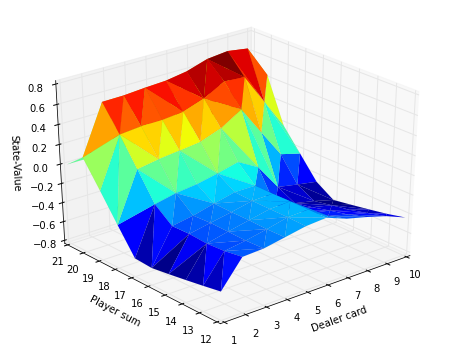

In [258]:
#3d plot of state-value space where no useable Aces are present
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d', )

ax.set_xlabel('Dealer card')
ax.set_ylabel('Player sum')
ax.set_zlabel('State-Value')

x,y,z = [],[],[]
for key in state_space:
    if (not key[1] and key[0] > 11 and key[2] < 21):
        y.append(key[0])
        x.append(key[2])
        state_value = max([av_table[(key, 0)], av_table[(key, 1)]])
        z.append(state_value)
ax.azim = 230
ax.plot_trisurf(x,y,z, linewidth=.02, cmap=cm.jet)

Looks pretty good to me. This isn't a major point, but notice that I plotted the State-Value on the z-axis, not an action value. I calculated the state value by simply taking the largest action value for a state from our state-action lookup table. Thus, the value of a state is equivalent to the average rewards following the best action.

Below I've used our action-value lookup table to build a crappy looking table that displays the optimal actions one should take in a game of blackjack given you're in a particular state. The left column are the possible player totals (given no useable ace) and the top row is the possible dealer cards. So you can lookup what's the best action to take if I have a total of 16 and the dealer is showing a 7 (the answer is "hit"). You can compare to wikipedia's article on blackjack that has a similar table: https://en.wikipedia.org/wiki/Blackjack#Basic_strategy  As you can tell, ours is pretty accurate.

<table><tr><th><td>Dealer</td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td><td></td></th></tr><tr><td>Player</td><td>1</td><td>2</td><td>3</td><td>4</td><td>5</td><td>6</td><td>7</td><td>8</td><td>9</td><td>10</td></tr><tr><td>12</td><td style='background-color:red;'>H</td><td style='background-color:red;'>H</td><td>S</td><td>S</td><td>S</td><td>S</td><td style='background-color:red;'>H</td><td style='background-color:red;'>H</td><td style='background-color:red;'>H</td><td style='background-color:red;'>H</td></tr><tr><td>13</td><td style='background-color:red;'>H</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td style='background-color:red;'>H</td><td style='background-color:red;'>H</td><td style='background-color:red;'>H</td><td style='background-color:red;'>H</td></tr><tr><td>14</td><td style='background-color:red;'>H</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td style='background-color:red;'>H</td><td style='background-color:red;'>H</td><td style='background-color:red;'>H</td><td style='background-color:red;'>H</td></tr><tr><td>15</td><td style='background-color:red;'>H</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td style='background-color:red;'>H</td><td style='background-color:red;'>H</td><td style='background-color:red;'>H</td><td style='background-color:red;'>H</td></tr><tr><td>16</td><td style='background-color:red;'>H</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td style='background-color:red;'>H</td><td style='background-color:red;'>H</td><td style='background-color:red;'>H</td><td style='background-color:red;'>H</td></tr><tr><td>17</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td></tr><tr><td>18</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td></tr><tr><td>19</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td></tr><tr><td>20</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td><td>S</td></tr></table>

###Conclusion & What's Next
Here we've covered Monte Carlo reinforcement learning methods that depending on stochastically sampling the environment and iteratively improving a policy $\pi$ after each episode. One disadvantage of Monte Carlo methods is that we must wait until the end of an episode to update our policy. For some types of problems (like blackjack), this is okay, but in a lot of cases, it makes more sense to able to learn at each time step (immediately after each action is taken).

The whole point of the Monte Carlo simulations were to build an action-value table. The action-value table basically _is_ our $Q(s,a)$ function. You give it a state and an action and it just goes and looks up the value in the table. The most important thing to learn from all of this is that in essentially any RL method, our goal is to find an optimal $Q$ function. Most of the differences between RL algorithms revolve around differences in determining Q-values. The policy function is straightforward, just pick the best action using $Q(s,a)$. We might throw in a softmax or something to add in some randomness, but there's not a lot more to $\pi(s)$.

In the next part, I will abandon tabular learning methods and cover Q-learning (a type of temporal difference (TD) algorithm) using a neural network as our $Q$ function (what we've all been waiting for).

This was a pretty meaty post so please email me (outlacedev@gmail.com) if you spot any errors or have any questions or comments.

###Download this IPython Notebook
https://github.com/outlace/outlace.github.io/blob/master/ipython-notebooks/rlpart2.ipynb

###References:
1. https://en.wikipedia.org/wiki/Blackjack
2. https://en.wikipedia.org/wiki/Monte_Carlo_method
3. "Reinforcement Learning: An Introduction" Sutton & Barto
4. https://inst.eecs.berkeley.edu/~cs188/sp08/projects/blackjack/blackjack.py (Adapted some code from here)
5. http://waxworksmath.com/Authors/N_Z/Sutton/WWW/Chapter_5/op_bj_results.html